In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

In [ ]:
# only the number of maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]
# drop all rows containing 0.5 to make it binary
print(len(all_data))
all_data = all_data.query('k6a1 != 0.5 & k6a2 != 0.5 & k11 != 0.5 & k12 != 0.5 & k9a1 != 0.5 & k9a2 != 0.5')
print(len(all_data))
#set the values to zero and one
#labels = ['k6a1','k6a2','k11','k12','k9a1','k9a2']
#[all_data[i].mask(all_data[i] == 0.25, 0, inplace=True) for i in labels]
#[all_data[i].mask(all_data[i] == 0.75, 1, inplace=True) for i in labels]
#print(all_data.head(10))
data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)

In [ ]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
#my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max_bucket)
feature_columns_A.append(no_of_max)
k6a1 = tf.feature_column.numeric_column("k6a1")
feature_columns_A.append(k6a1)
k6a2 = tf.feature_column.numeric_column("k6a2")
feature_columns_A.append(k6a2)
k11 = tf.feature_column.numeric_column("k11")
feature_columns_A.append(k11)
k12 = tf.feature_column.numeric_column("k12")
feature_columns_A.append(k12)
k9a1 = tf.feature_column.numeric_column("k9a1")
feature_columns_A.append(k9a1)
k9a2 = tf.feature_column.numeric_column("k9a2")
feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()

In [ ]:
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=6,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    features = {name:np.array(value) for name, value in dataset.items()}
    label=dataset[label_name].to_numpy()
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [ ]:
learning_rate = 1e-2
epochs = 50
batch_size = 12

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]
#label_name = "k6a1"
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="sigmoid")
epochs, hist = train_model(my_model, data_train, epochs, 
                          label_name, batch_size)
# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
features = {name:np.array(value) for name, value in data_test.items()}
label=data_test[label_name].to_numpy()
print("\n Evaluate the new model against the test set:")
evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)
predicted = my_model.predict(features)
print(predicted)
df_test=pd.DataFrame(label,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_hat"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head()

# Umbauen in ein echtes Klassifizierungsproblem

see https://sebastianraschka.com/faq/docs/softmax_regression.html

Wir haben für jede Konstante drei mögliche Werte: 0.25, 0.5 und 0.75 - das ist somit ein "ternary" (dreifaltiges?) Klassifikationsproblem. Die softmax Funktion am Ende des Modells gibt eine Wahrscheinlichkeit an, inwiefern das "feature" zu welcher Klasse gehört (prozentual). 

Ich würde mal anfangen und für k6a1 ein Modell bauen mit one-hot encoding für die drei möglichen Werte und als feature die Anzahl der Peaks. Das gleiche für ausschliesslich k6a2, k11, k12, k9a1, k9a2. Vermutlich wird das nicht so gut funktionieren weil die Information einfach nicht ausreichend ist. Da würde ich mal versuchen zu verstehen, welche Vorhersagen dir das Modell gibt, und dass du die Wahrscheinlichkeiten für die drei möglichen Klassen bekommst, für jedes Beispiel.

Im zweiten Schritt würde ich dann andere Klassen-Kombinationen probieren:
Klasse 1 - k6a1, k11, k9a1 
Klasse 2 - k6a2, k12, k9a2 

Sagen wir, die jeweiligen Werte liegen bei -1 (momentan 0.25), 0 (momentan 0.5), 1 (momentan 0.75). Die Summe aller Werte liegt damit zwischen -3 und +3.

Dann wäre Fall A: sum(Klasse 1) < -1; Fall B: -1 < sum(Klasse 1) < 1; Fall C: sum(Klasse 1) > 1. Mit den Grenzen kann man etwas herumspielen; und das gleiche jeweils für Klasse 2.

Oder vielleicht hast du noch andere Ideen.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

In [ ]:
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]

all_data=pd.get_dummies(all_data,columns=["k6a1","k6a2","k11","k12","k9a1","k9a2"])


#all_data["k6a1"]=all_data[["k6a1_0.25","k6a1_0.5","k6a1_0.75"]].values.tolist()
#all_data["k6a2"]=all_data[["k6a1_0.25","k6a1_0.5","k6a1_0.75"]].values.tolist()
#all_data["k11"]=all_data[["k11_0.25","k11_0.5","k11_0.75"]].values.tolist()
#all_data["k12"]=all_data[["k12_0.25","k12_0.5","k12_0.75"]].values.tolist()
#all_data["k9a1"]=all_data[["k9a1_0.25","k9a1_0.5","k9a1_0.75"]].values.tolist()
#all_data["k9a2"]=all_data[["k9a2_0.25","k9a2_0.5","k9a2_0.75"]].values.tolist()
#all_data=all_data.drop(columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75","k6a2_0.25","k6a2_0.5","k6a2_0.75","k11_0.25",
#                                "k11_0.5","k11_0.75","k12_0.25","k12_0.5","k12_0.75","k9a1_0.25","k9a1_0.5",
#                                "k9a1_0.75","k9a2_0.25","k9a2_0.5","k9a2_0.75"])

data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)
data_train.head()

In [ ]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
#my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max_bucket)
feature_columns_A.append(no_of_max)
#k6a1 = tf.feature_column.numeric_column("k6a1")
#feature_columns_A.append(k6a1)
#k6a2 = tf.feature_column.numeric_column("k6a2")
#feature_columns_A.append(k6a2)
#k11 = tf.feature_column.numeric_column("k11")
#feature_columns_A.append(k11)
#k12 = tf.feature_column.numeric_column("k12")
#feature_columns_A.append(k12)
#k9a1 = tf.feature_column.numeric_column("k9a1")
#feature_columns_A.append(k9a1)
#k9a2 = tf.feature_column.numeric_column("k9a2")
#feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)




def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=18,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)

    #for multiple inputs
    print(type(label_name))
    if(type(label_name)==list):
        label=dataset[label_name].to_numpy()
        label_array=np.zeros((label.shape[0],label.shape[1],3))
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                for k in range(len(label[i,j])):
                    label_array[i,j,k]=label[i,j][k]
            #print(label_array[i,j])
           # print(type(label_array[i,j]))
        print(label_array.shape) 
        label=label_array
    else:
        label=dataset[label_name].to_numpy()
        label_array=np.zeros((label.shape[0],3))
        for i in range(label.shape[0]):
            for k in range(len(label[i])):
                label_array[i,k]=label[i][k]
          
        print(label_array.shape) 
        label=label_array
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist


def train_model2(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)
    label=dataset[label_name].to_numpy()

    
    
    
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [ ]:
learning_rate = 1e-1
epochs = 500
batch_size = 12

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

#label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]
#label_name = "k6a1"
label_name=["k6a1_0.25","k6a1_0.5","k6a1_0.75","k6a2_0.25","k6a2_0.5","k6a2_0.75","k11_0.25","k11_0.5","k11_0.75","k12_0.25","k12_0.5","k12_0.75","k9a1_0.25","k9a1_0.5","k9a1_0.75","k9a2_0.25","k9a2_0.5","k9a2_0.75"]
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="softmax")

# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 


In [ ]:
epochs, hist = train_model2(my_model, data_train, epochs, 
                          label_name, batch_size)

In [ ]:
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

if(type(label_name)==list):
    label=data_test[label_name].to_numpy()
    label_array=np.zeros((label.shape[0],label.shape[1],3))
    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            for k in range(len(label[i,j])):
                label_array[i,j,k]=label[i,j][k]
        #print(label_array[i,j])
       # print(type(label_array[i,j]))
    #print(label_array.shape) 
    label=label_array
else:
    label=data_test[label_name].to_numpy()
    label_array=np.zeros((label.shape[0],3))
    for i in range(label.shape[0]):
        for k in range(len(label[i])):
            label_array[i,k]=label[i][k]

    #print(label_array.shape) 
    label=label_array


In [ ]:
features={"no_of_max":data_test["no_of_max"].to_numpy()}
label=data_test[label_name].to_numpy()
#print(label.reshape((len(label),6,3)))

print("\n Evaluate the new model against the test set:")




evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)

predicted = my_model.predict(features)

label=label.reshape((len(label),6,3))

predicted=predicted.reshape((len(predicted),6,3))
print(predicted.shape)

label_list=["k6a1","k6a2","k11","k12","k9a1","k9a2"]
for i in range(predicted.shape[0]):
    print("Test No:", i)
    for j in range(predicted.shape[1]):
        #print(1/sum(predicted[i,j]))
        print(label_list[j],"Label: ",label[i,j],"predicted: ", predicted[i,j]*1/sum(predicted[i,j]) )
print()

        
  


df_test=pd.DataFrame(label,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_0.25_label","k6a1_0.5_label","k6a1_0.75_label"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head(50)

In [1]:
#class predictions
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub

In [2]:
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]
no_data_points=(len(all_data["k6a1"].values))
#all_data=pd.get_dummies(all_data,columns=["k6a1","k6a2","k11","k12","k9a1","k9a2"])

#values between 0.75 and 2.25
#different classes:
#0 all < 0.5
#1 all > 0.5
#2 k6a1,k11,k9a1 >0.5, k6a2,k11,k9a2 <0.5
#3 k6a1,k11,k9a1 <0.5, k6a2,k11,k9a2 >0.5
#4 k6a1 == k6a2 
#5 k11 == k12 
#6 k9a1 == k9a2 
#7 sum(k6a1,k11,k9a1) < 1.25
#8 sum(k6a1,k11,k9a1) > 2
#9 sum(k6a2,k12,k9a2) < 1.25
#10 sum(k6a2,k12,k9a2) > 2

print(all_data.head())
#class_array=np.zeros((no_data_points,11))
all_data.loc[(all_data['k6a1'] <0.5) & (all_data['k6a2'] <0.5)& (all_data['k11'] <0.5)
                        & (all_data['k12'] <0.5)& (all_data['k9a1'] <0.5)&( all_data['k9a2'] <0.5), 'Class0'] = 1  
all_data.loc[(all_data['k6a1'] >0.5) & (all_data['k6a2'] >0.5)& (all_data['k11'] >0.5)
                        & (all_data['k12'] >0.5)& (all_data['k9a1'] >0.5)&( all_data['k9a2'] >0.5), 'Class1'] = 1  

all_data.loc[(all_data['k6a1'] >0.5) & (all_data['k6a2'] <0.5)& (all_data['k11'] >0.5)
                        & (all_data['k12'] <0.5)& (all_data['k9a1'] >0.5)&( all_data['k9a2'] <0.5), 'Class2'] = 1  
all_data.loc[(all_data['k6a1'] <0.5) & (all_data['k6a2'] >0.5)& (all_data['k11'] <0.5)
                        & (all_data['k12'] >0.5)& (all_data['k9a1'] <0.5)&( all_data['k9a2'] >0.5), 'Class3'] = 1  
all_data.loc[(all_data['k6a1'] == all_data['k6a2']), 'Class4'] = 1  
all_data.loc[(all_data['k11'] == all_data['k12']), 'Class5'] = 1  
all_data.loc[(all_data['k9a1'] == all_data['k9a2']), 'Class6'] = 1  
all_data.loc[((all_data['k6a1']+all_data['k11']+all_data['k9a1'])<1.25 ), 'Class7'] = 1  
all_data.loc[((all_data['k6a1']+all_data['k11']+all_data['k9a1'])>2 ), 'Class8'] = 1  
all_data.loc[((all_data['k6a2']+all_data['k12']+all_data['k9a2'])<1.25 ), 'Class9'] = 1  
all_data.loc[((all_data['k6a2']+all_data['k12']+all_data['k9a2'])>2 ), 'Class10'] = 1  








all_data=all_data.fillna(0)


data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)
data_train.head()


   k6a1  k6a2   k11   k12  k9a1  k9a2  no_of_max
0  0.25  0.25  0.25  0.25  0.25  0.25         18
1  0.25  0.25  0.25  0.25  0.25  0.50          5
2  0.25  0.25  0.25  0.25  0.25  0.75         19
3  0.25  0.25  0.25  0.25  0.50  0.25         19
4  0.25  0.25  0.25  0.25  0.50  0.50          5


H:\Users\Gwydion\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
H:\Users\Gwydion\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,k6a1,k6a2,k11,k12,k9a1,k9a2,no_of_max,Class0,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
247,0.50,0.25,0.25,0.25,0.50,0.50,5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
335,0.50,0.50,0.25,0.50,0.25,0.75,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
701,0.75,0.75,0.50,0.75,0.75,0.75,19,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
440,0.50,0.75,0.50,0.25,0.75,0.75,19,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
136,0.25,0.50,0.75,0.25,0.25,0.50,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
feature_columns_A.append(no_of_max)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)




def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=11,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model

def train_model2(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(np.asarray(value)) for name, value in dataset.items()}

    features={"no_of_max":dataset["no_of_max"].to_numpy()}
   # print(features)
    label=dataset[label_name].to_numpy()

    
    
    
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [4]:
learning_rate = 1e-1
epochs = 500
batch_size = 12

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

label_name=["Class0","Class1","Class2","Class3","Class4","Class5","Class6","Class7","Class8","Class9","Class10"]
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="softmax")

# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 


In [5]:
epochs, hist = train_model2(my_model, data_train, epochs, 
                          label_name, batch_size)

Epoch 1/500
49/49 [==============================] - 0s 684us/step - loss: 0.2988 - accuracy: 0.7719 - precision: 0.3170 - recall: 0.7218  
Epoch 2/500
49/49 [==============================] - 0s 655us/step - loss: 0.2940 - accuracy: 0.7736 - precision: 0.3213 - recall: 0.7368
Epoch 3/500
49/49 [==============================] - 0s 618us/step - loss: 0.2942 - accuracy: 0.7670 - precision: 0.3163 - recall: 0.7506
Epoch 4/500
49/49 [==============================] - 0s 637us/step - loss: 0.2932 - accuracy: 0.7631 - precision: 0.3143 - recall: 0.7644
Epoch 5/500
49/49 [==============================] - 0s 600us/step - loss: 0.2927 - accuracy: 0.7630 - precision: 0.3092 - recall: 0.7331
Epoch 6/500
49/49 [==============================] - 0s 618us/step - loss: 0.2944 - accuracy: 0.7695 - precision: 0.3162 - recall: 0.7331
Epoch 7/500
49/49 [==============================] - 0s 600us/step - loss: 0.2966 - accuracy: 0.7625 - precision: 0.3109 - recall: 0.7469
Epoch 8/500
49/49 [=============

Epoch 60/500
49/49 [==============================] - 0s 600us/step - loss: 0.2917 - accuracy: 0.7658 - precision: 0.3126 - recall: 0.7356
Epoch 61/500
49/49 [==============================] - 0s 582us/step - loss: 0.2883 - accuracy: 0.7636 - precision: 0.3163 - recall: 0.7744
Epoch 62/500
49/49 [==============================] - 0s 582us/step - loss: 0.2909 - accuracy: 0.7666 - precision: 0.3136 - recall: 0.7368
Epoch 63/500
49/49 [==============================] - 0s 564us/step - loss: 0.2916 - accuracy: 0.7691 - precision: 0.3211 - recall: 0.7682
Epoch 64/500
49/49 [==============================] - 0s 600us/step - loss: 0.2887 - accuracy: 0.7681 - precision: 0.3161 - recall: 0.7419
Epoch 65/500
49/49 [==============================] - 0s 600us/step - loss: 0.2890 - accuracy: 0.7642 - precision: 0.3141 - recall: 0.7556
Epoch 66/500
49/49 [==============================] - 0s 618us/step - loss: 0.2885 - accuracy: 0.7649 - precision: 0.3161 - recall: 0.7644
Epoch 67/500
49/49 [=======

49/49 [==============================] - 0s 600us/step - loss: 0.2880 - accuracy: 0.7706 - precision: 0.3205 - recall: 0.7531
Epoch 119/500
49/49 [==============================] - 0s 582us/step - loss: 0.2893 - accuracy: 0.7655 - precision: 0.3169 - recall: 0.7657
Epoch 120/500
49/49 [==============================] - 0s 600us/step - loss: 0.2884 - accuracy: 0.7686 - precision: 0.3176 - recall: 0.7481
Epoch 121/500
49/49 [==============================] - 0s 600us/step - loss: 0.2943 - accuracy: 0.7734 - precision: 0.3233 - recall: 0.7506
Epoch 122/500
49/49 [==============================] - 0s 600us/step - loss: 0.2879 - accuracy: 0.7698 - precision: 0.3203 - recall: 0.7569
Epoch 123/500
49/49 [==============================] - 0s 600us/step - loss: 0.2886 - accuracy: 0.7672 - precision: 0.3182 - recall: 0.7619
Epoch 124/500
49/49 [==============================] - 0s 600us/step - loss: 0.2896 - accuracy: 0.7658 - precision: 0.3165 - recall: 0.7607
Epoch 125/500
49/49 [=============

49/49 [==============================] - 0s 564us/step - loss: 0.3332 - accuracy: 0.7672 - precision: 0.3156 - recall: 0.7456
Epoch 177/500
49/49 [==============================] - 0s 564us/step - loss: 0.3353 - accuracy: 0.7599 - precision: 0.3115 - recall: 0.7682
Epoch 178/500
49/49 [==============================] - 0s 582us/step - loss: 0.3331 - accuracy: 0.7686 - precision: 0.3174 - recall: 0.7469
Epoch 179/500
49/49 [==============================] - 0s 582us/step - loss: 0.3344 - accuracy: 0.7659 - precision: 0.3166 - recall: 0.7607
Epoch 180/500
49/49 [==============================] - 0s 582us/step - loss: 0.3022 - accuracy: 0.7624 - precision: 0.3157 - recall: 0.7794
Epoch 181/500
49/49 [==============================] - 0s 612us/step - loss: 0.2912 - accuracy: 0.7661 - precision: 0.3168 - recall: 0.7607
Epoch 182/500
49/49 [==============================] - 0s 618us/step - loss: 0.2881 - accuracy: 0.7661 - precision: 0.3166 - recall: 0.7594
Epoch 183/500
49/49 [=============

49/49 [==============================] - 0s 582us/step - loss: 0.2902 - accuracy: 0.7675 - precision: 0.3187 - recall: 0.7632
Epoch 235/500
49/49 [==============================] - 0s 577us/step - loss: 0.2922 - accuracy: 0.7670 - precision: 0.3155 - recall: 0.7456
Epoch 236/500
49/49 [==============================] - 0s 600us/step - loss: 0.2902 - accuracy: 0.7683 - precision: 0.3151 - recall: 0.7343
Epoch 237/500
49/49 [==============================] - 0s 582us/step - loss: 0.2883 - accuracy: 0.7726 - precision: 0.3214 - recall: 0.7444
Epoch 238/500
49/49 [==============================] - 0s 582us/step - loss: 0.2926 - accuracy: 0.7737 - precision: 0.3217 - recall: 0.7381
Epoch 239/500
49/49 [==============================] - 0s 582us/step - loss: 0.2884 - accuracy: 0.7656 - precision: 0.3161 - recall: 0.7594
Epoch 240/500
49/49 [==============================] - 0s 582us/step - loss: 0.2891 - accuracy: 0.7703 - precision: 0.3210 - recall: 0.7581
Epoch 241/500
49/49 [=============

49/49 [==============================] - 0s 582us/step - loss: 0.2908 - accuracy: 0.7694 - precision: 0.3201 - recall: 0.7594
Epoch 293/500
49/49 [==============================] - 0s 600us/step - loss: 0.2906 - accuracy: 0.7675 - precision: 0.3202 - recall: 0.7732
Epoch 294/500
49/49 [==============================] - 0s 582us/step - loss: 0.2885 - accuracy: 0.7658 - precision: 0.3169 - recall: 0.7632
Epoch 295/500
49/49 [==============================] - 0s 618us/step - loss: 0.2886 - accuracy: 0.7692 - precision: 0.3157 - recall: 0.7318
Epoch 296/500
49/49 [==============================] - 0s 637us/step - loss: 0.2905 - accuracy: 0.7705 - precision: 0.3198 - recall: 0.7494
Epoch 297/500
49/49 [==============================] - 0s 582us/step - loss: 0.2911 - accuracy: 0.7681 - precision: 0.3157 - recall: 0.7393
Epoch 298/500
49/49 [==============================] - 0s 618us/step - loss: 0.2900 - accuracy: 0.7734 - precision: 0.3227 - recall: 0.7469
Epoch 299/500
49/49 [=============

49/49 [==============================] - 0s 600us/step - loss: 0.2878 - accuracy: 0.7726 - precision: 0.3210 - recall: 0.7419
Epoch 351/500
49/49 [==============================] - 0s 564us/step - loss: 0.2895 - accuracy: 0.7663 - precision: 0.3168 - recall: 0.7594
Epoch 352/500
49/49 [==============================] - 0s 564us/step - loss: 0.2886 - accuracy: 0.7659 - precision: 0.3204 - recall: 0.7857
Epoch 353/500
49/49 [==============================] - 0s 582us/step - loss: 0.2889 - accuracy: 0.7673 - precision: 0.3152 - recall: 0.7419
Epoch 354/500
49/49 [==============================] - 0s 600us/step - loss: 0.2883 - accuracy: 0.7700 - precision: 0.3169 - recall: 0.7343
Epoch 355/500
49/49 [==============================] - 0s 564us/step - loss: 0.2885 - accuracy: 0.7663 - precision: 0.3166 - recall: 0.7581
Epoch 356/500
49/49 [==============================] - 0s 593us/step - loss: 0.2923 - accuracy: 0.7664 - precision: 0.3148 - recall: 0.7456
Epoch 357/500
49/49 [=============

49/49 [==============================] - 0s 618us/step - loss: 0.2896 - accuracy: 0.7653 - precision: 0.3164 - recall: 0.7632
Epoch 409/500
49/49 [==============================] - 0s 637us/step - loss: 0.2891 - accuracy: 0.7681 - precision: 0.3184 - recall: 0.7569
Epoch 410/500
49/49 [==============================] - 0s 637us/step - loss: 0.2894 - accuracy: 0.7739 - precision: 0.3217 - recall: 0.7368
Epoch 411/500
49/49 [==============================] - 0s 637us/step - loss: 0.2902 - accuracy: 0.7741 - precision: 0.3240 - recall: 0.7506
Epoch 412/500
49/49 [==============================] - 0s 600us/step - loss: 0.2889 - accuracy: 0.7711 - precision: 0.3209 - recall: 0.7519
Epoch 413/500
49/49 [==============================] - 0s 618us/step - loss: 0.2902 - accuracy: 0.7705 - precision: 0.3178 - recall: 0.7368
Epoch 414/500
49/49 [==============================] - 0s 600us/step - loss: 0.2889 - accuracy: 0.7644 - precision: 0.3152 - recall: 0.7619
Epoch 415/500
49/49 [=============

49/49 [==============================] - 0s 600us/step - loss: 0.2921 - accuracy: 0.7697 - precision: 0.3212 - recall: 0.7644
Epoch 467/500
49/49 [==============================] - 0s 582us/step - loss: 0.2890 - accuracy: 0.7661 - precision: 0.3153 - recall: 0.7506
Epoch 468/500
49/49 [==============================] - 0s 600us/step - loss: 0.2888 - accuracy: 0.7684 - precision: 0.3210 - recall: 0.7719
Epoch 469/500
49/49 [==============================] - 0s 582us/step - loss: 0.2879 - accuracy: 0.7694 - precision: 0.3154 - recall: 0.7293
Epoch 470/500
49/49 [==============================] - 0s 637us/step - loss: 0.2918 - accuracy: 0.7672 - precision: 0.3160 - recall: 0.7481
Epoch 471/500
49/49 [==============================] - 0s 618us/step - loss: 0.2871 - accuracy: 0.7677 - precision: 0.3175 - recall: 0.7544
Epoch 472/500
49/49 [==============================] - 0s 601us/step - loss: 0.2882 - accuracy: 0.7720 - precision: 0.3192 - recall: 0.7343
Epoch 473/500
49/49 [=============

In [11]:
features={"no_of_max":data_test["no_of_max"].to_numpy()}
label=data_test[label_name].to_numpy()
#print(label.reshape((len(label),6,3)))

print("\n Evaluate the new model against the test set:")




evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)

predicted = my_model.predict(features)

#label=label.reshape((len(label),6,3))

#predicted=predicted.reshape((len(predicted),6,3))
print(predicted.shape)


        
  


df_test=pd.DataFrame(label,columns=["0_test","1_test","2_test","3_test","4_test","Class5_test","Class6_test","Class7_test","Class8_test","Class9_test","Class10_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_0.25_label","k6a1_0.5_label","k6a1_0.75_label"])
df_predict=pd.DataFrame(predicted,columns=["Class0","Class1","Class2","Class3","Class4","Class5","Class6","Class7","Class8","Class9","Class10"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_0.25","k6a1_0.5","k6a1_0.75"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head(50)


 Evaluate the new model against the test set:
13/13 [==============================] - 0s 548us/step - loss: 0.2853 - accuracy: 0.7902 - precision: 0.3493 - recall: 0.7463
(146, 11)


,0_test,1_test,2_test,3_test,4_test,Class5_test,Class6_test,Class7_test,Class8_test,Class9_test,...,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000024,0.000035,0.000037,0.193618,0.217697,0.350477,0.076218,0.035158,0.126288,0.000411
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000006,0.000008,0.000009,0.211887,0.253394,0.402898,0.084645,0.038762,0.008377,0.000003
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000467,0.000762,0.000783,0.189280,0.195154,0.342920,0.070965,0.032187,0.087597,0.079162
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.000006,0.000008,0.000009,0.211887,0.253394,0.402898,0.084645,0.038762,0.008377,0.000003
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000467,0.000762,0.000783,0.189280,0.195154,0.342920,0.070965,0.032187,0.087597,0.079162
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000467,0.000762,0.000783,0.189280,0.195154,0.342920,0.070965,0.032187,0.087597,0.079162
6,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000467,0.000762,0.000783,0.189280,0.195154,0.342920,0.070965,0.032187,0.087597,0.079159
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.000024,0.000035,0.000037,0.193618,0.217697,0.350477,0.076218,0.035158,0.126288,0.000411
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000006,0.000008,0.000009,0.211887,0.253394,0.402898,0.084645,0.038762,0.008377,0.000003
9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.000024,0.000035,0.000037,0.193618,0.217697,0.350477,0.076218,0.035158,0.126288,0.000411


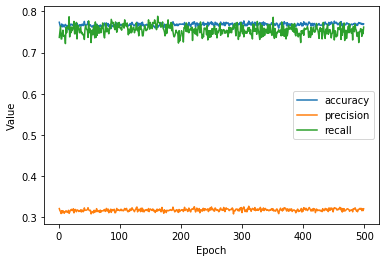

In [10]:
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)